# Банки — Сегментация пользователей по потреблению

## Общие сведения по проекту

**Краткое описание:** имеются данные о клиентах банка «Метанпром», который располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Цель —** необходимо проанализировать клиентов регионального банка, сегментировать пользователей по количеству потребляемых продуктов и предложить рекомендации.

**Описание данных:**
* `userid` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `City` — город,
* `Gender` — пол,
* `Age` — возраст,
* `Objects` — количество объектов в собственности,
* `Balance` — баланс на счёте,
* `Products` — количество продуктов, которыми пользуется клиент,
* `CreditCard` — есть ли кредитная карта,
* `Loyalty` — активный клиент,
* `estimated_salary` — заработная плата клиента,
* `Churn` — ушёл или нет.

**План работы:**
* Провести исследовательский анализ данных;
* Сегментировать пользователей на основе данных о количестве потребляемых продуктов;
* Сформулировать и проверить статистические гипотезы:
1. гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
2. сформулировать и проверить статистическую гипотезу относительно представленных данных.

## Загрузка данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Открытие файла с использованием конструкции try-except
try:
    df = pd.read_csv('C:/Users/ADMIN/Downloads/12_final/bank_dataset.csv') # Локальный путь
except:
    df = pd.read_csv('/datasets/bank_dataset.csv') # Серверный путь

In [3]:
# Снятие ограничений на отражение максимального коливества столбцов
pd.set_option('display.max_columns', None)

## Общая информация и предобработка данных

### Общая информация о датафрейме

In [4]:
# Вывод информации о датафрейме
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,count,mean,std,min,25%,50%,75%,max
userid,10000.0,1.573368e+07,71936.186123,15608437.00,1.567126e+07,1.573347e+07,1.579597e+07,15858426.00
score,10000.0,6.505288e+02,96.653299,350.00,5.840000e+02,6.520000e+02,7.180000e+02,850.00
Age,10000.0,3.892180e+01,10.487806,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
Objects,10000.0,5.012800e+00,2.892174,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
Balance,6383.0,1.198275e+05,30095.056462,3768.69,1.001820e+05,1.198397e+05,1.395123e+05,250898.09
Products,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
CreditCard,10000.0,7.055000e-01,0.455840,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
Loyalty,10000.0,5.151000e-01,0.499797,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,5.100211e+04,1.001939e+05,1.493882e+05,199992.48
Churn,10000.0,2.037000e-01,0.402769,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.00


**Вывод:**
* в исходных данных 10 000 записей и 11 столбцов, есть пропуски по столбцу `Balance` (баланс на счёте);
* баллы кредитного скоринга от 350 до 850;
* возраст клиентов от 18 до 92 лет (средний - 39 лет);
* количество объектов в собственности от 0 до 10 (в среднем 5);
* баланс на счёте от 3 769 до 250 898 (в среднем 119 827);
* количество продуктов, которыми пользуется клиент от 1 до 4;
* заработная плата клиента от 12 до 199 992.

При проверке аномальных данных стоит обратить внимание на `estimated_salary`(заработная плата клиента).

Для удобства дальнейшего анализа данных пo признаку `Gender`, возможно изменение типа на `int`.

### Проверка на соответствие стилю python

In [5]:
# Приведение наимнований столбцов к стилю python
df.columns = df.columns.str.lower()

# Добавление разделителя "_" 
df.rename(columns = {'userid':'user_id', 'creditcard':'credit_card'}, inplace = True)

# Уникальные значения по признаку 'gender'
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [6]:
# Замена пола: М = 1, Ж = 0
df['gender'] = df['gender'].replace({'Ж':0, 'М': 1})

# Именение типа данных для удобства при последующей работе с данными
df['gender'] = df['gender'].astype('int64')

In [7]:
# Получение первых 5 строк таблицы df
df.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,0,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,0,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,0,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,0,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,0,43,2,125510.82,1,1,1,79084.10,0


**Вывод:** название столбцов скорректировано в соответствии со стилем python (нижний курсив + разделитель "_").

### Проверка на пропуски, их исследование в разрезе остальных признаков с выдвижением гипотезы

In [8]:
# Подсчёт пропусков
df.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

In [9]:
# Расчет доли пропусков
df['balance'].isna().sum() / len(df['balance'])

0.3617

Доля пропусков составляет 1/3 от имеющихся данных по балансу на счете. 

Исключение пропусков приведет к искажению дальнейшего анализа данных.

In [10]:
# Заполнение пропущенных значений нулями
df['balance'] = df['balance'].fillna(0)

# Именение типа данных для удобства при последующей работе с данными
df['balance'] = df['balance'].astype('int64')
df['estimated_salary'] = df['estimated_salary'].astype('int64')

In [11]:
# Создание датафрема с пропусками по балансу
zero_balance = df[df['balance'] == 0]

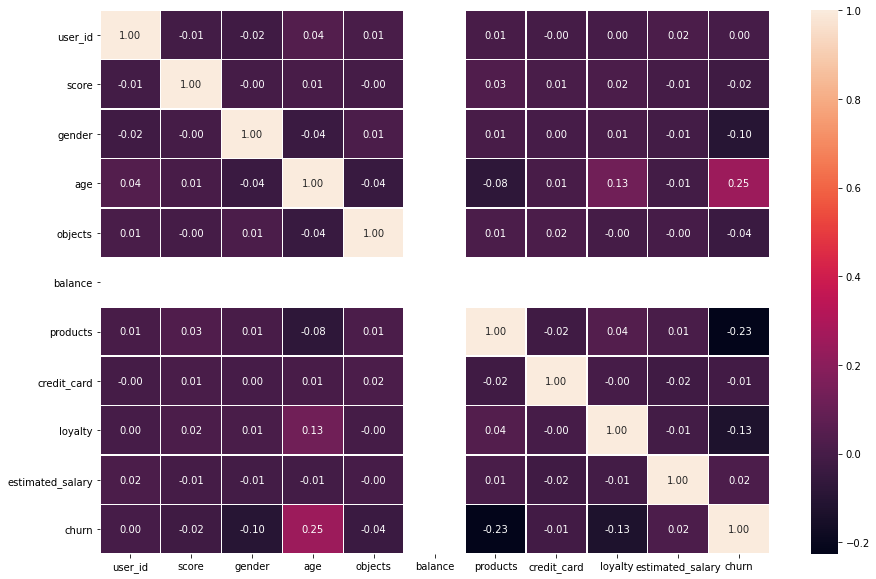

In [12]:
# Создание корреляционной матрицы
corr_matrix = zero_balance.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix , annot = True, fmt = '0.2f', linewidths=.5)
plt.show()

Явной зависимости между данными с пропусками по корреляционной матрице не выявлено.

In [13]:
# Определение цветового градиента для вывода таблиц
cm = sns.light_palette("blue", as_cmap=True)

# Создание сводной таблицы по датафрейму с пропусками
zero_balance.pivot_table(index = ['city', 'products'], columns = ['churn'], values = 'user_id', aggfunc = 'count', margins=True).style.background_gradient(cmap=cm)

Пропуски в балансе встречаются только в Ярославле и Рыбинске. В отток попали 500 из 3617, при этом не осталось клиентов, которые воспользовались всеми 4 продуктами банка.

In [14]:
# Создание сводной таблицы по общему датафрейму для сравнения
df.pivot_table(index = ['city', 'products'], columns = ['churn'], values = 'user_id', aggfunc = 'count', margins=True).style.background_gradient(cmap=cm)

В Растове Великом так же не осталось клиентов, которые воспользовались всеми 4 продуктами банка, но пропуски отсутствуют. 

In [15]:
# Подсчет количества кредитных кард в датафрейме с пропусками
zero_balance['credit_card'].value_counts()

1    2592
0    1025
Name: credit_card, dtype: int64

In [16]:
# Подсчет количества кредитных кард в датафрейме
df['credit_card'].value_counts()

1    7055
0    2945
Name: credit_card, dtype: int64

**Выводы:** 
* один из продуктов банка - это закрытие счета;
* кредитные карты имеют 2/3 клиентов банка (в т.ч. с нулевым балансом);
* пропуски только в двух городах из трех и прямой зависимости не выявлено;
* возможные причины пропусков: технический сбой в Ярославле и Рыбинске (следует сравнить работу системы с Растовом Великим); отсутствие данных или отсутствие банковского счета (одновго из продуктов) при оформлении.

### Проверка наличия аномальных данных

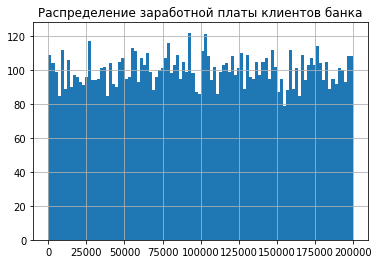

In [17]:
# Построение гистограммы по заработной плате клиента
df['estimated_salary'].hist(bins=100)
plt.title('Распределение заработной платы клиентов банка')
plt.show()

Наблюдается равномерное распределение заработной платы.

In [18]:
# Создание датафрема с доходом клиентов меньше минимального размер оплаты труда (15 279 руб. с 01.06.2022)
poor = df[df['estimated_salary'] < 15279]

# Вывод информации о датафрейме
poor.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,761.0,1.573150e+07,71833.939086,15608947.0,15671044.0,15728955.0,15792319.0,15858164.0
score,761.0,6.450604e+02,98.436122,412.0,578.0,645.0,711.0,850.0
gender,761.0,5.492773e-01,0.497893,0.0,0.0,1.0,1.0,1.0
age,761.0,3.868857e+01,10.467066,18.0,31.0,37.0,43.0,77.0
objects,761.0,4.932983e+00,2.855646,0.0,2.0,5.0,7.0,10.0
balance,761.0,6.996191e+04,62892.688281,0.0,0.0,89276.0,124442.0,204510.0
products,761.0,1.537451e+00,0.574894,1.0,1.0,2.0,2.0,4.0
credit_card,761.0,6.806833e-01,0.466519,0.0,0.0,1.0,1.0,1.0
loyalty,761.0,5.177398e-01,0.500014,0.0,0.0,1.0,1.0,1.0
estimated_salary,761.0,7.496445e+03,4423.223811,11.0,3626.0,7611.0,11159.0,15246.0


С учетом нулевых значений по балансу, средняя сумма сбережений 69 962 - большие значения для клиентов с доходом менее 1 МРОТ.

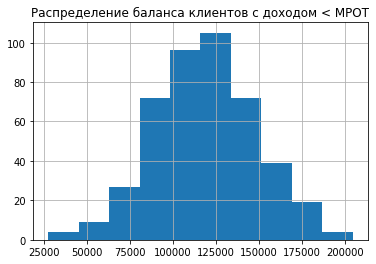

In [19]:
# Построение гистограммы баланса клиентов с доходом < МРОТ без учета пропусков
poor.query('balance != 0').balance.hist()
plt.title('Распределение баланса клиентов с доходом < МРОТ')
plt.show()

**Вывод:** равномерное распредедление заработной платы говорит об использовании алгоритма заполнения данных, который стоит проверить/доработать, т.к. клиенты с доходом меньше МРОТ имеют на счету значительные суммы сбережений.

### Проверка на дубликаты

In [20]:
# Подсчет количества дубликатов
df.duplicated().sum()

0

**Вывод:** дубликаты отсутствуют.

## Сегментация данных по количеству потребляемых продуктов

In [21]:
# группировка данных по количеству потребляемых продуктов
df.groupby('products')['user_id'].count()

products
1    5084
2    4590
3     266
4      60
Name: user_id, dtype: int64

In [22]:
# Создание функции распределения по количеству потребляемых продуктов

def products_segment(df):    
    if df['products'] == 1:
        return 'один продукт'    
    elif df['products'] == 2:
        return 'два продукта'    
    else:
        return '3-4 продукта'

# Добавление столбца сегдмента в датафрейм
df['products_segment'] = df.apply(products_segment, axis=1)

# Создание датафремов по сегментам
segment_1 = df.query('products_segment == "один продукт"')
segment_2 = df.query('products_segment == "два продукта"')
segment_3 = df.query('products_segment == "3-4 продукта"')

# Проверка
df.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,products_segment
0,15677338,619,Ярославль,0,42,2,0,1,1,1,101348,1,один продукт
1,15690047,608,Рыбинск,0,41,1,83807,1,0,1,112542,0,один продукт
2,15662040,502,Ярославль,0,42,8,159660,3,1,0,113931,1,3-4 продукта
3,15744090,699,Ярославль,0,39,1,0,2,0,0,93826,0,два продукта
4,15780624,850,Рыбинск,0,43,2,125510,1,1,1,79084,0,один продукт


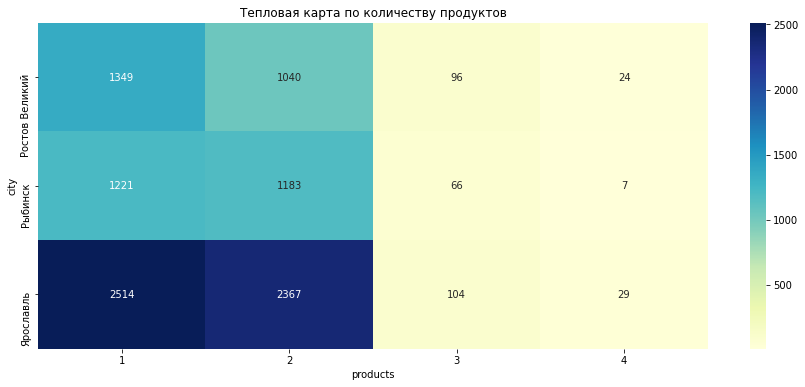

In [23]:
# Построение тепловой карты по количеству потребляемых продуктов
products_heap_map = df\
    .pivot_table(
        index='city',
        columns='products',
        values='user_id',
        aggfunc='count'
    )
plt.figure(figsize=(15, 6))
sns.heatmap(products_heap_map, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Тепловая карта по количеству продуктов')
plt.show()

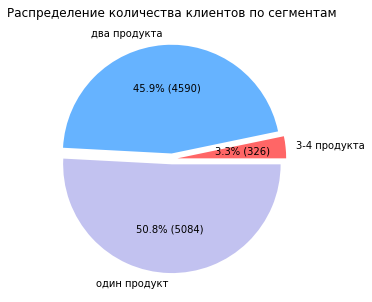

In [24]:
# Построение круговой диаграммы по количеству клиентов
df.groupby('products_segment')['user_id'].count().plot(kind='pie', figsize=[5,5], explode = (0.05, 0.05, 0.05), 
                                                       colors = ['#ff6666', '#66b3ff','#c2c2f0'],
                                                       autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*len(df['user_id'])))
plt.title('Распределение количества клиентов по сегментам')
plt.ylabel('')
plt.show()

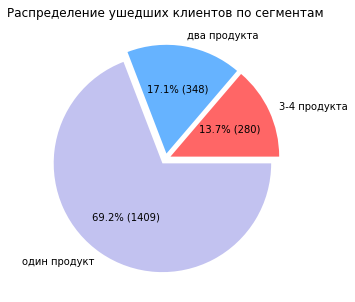

In [25]:
# Построение круговой диаграммы по оттоку
df.groupby('products_segment')['churn'].sum().plot(kind='pie', figsize=[5,5], explode = (0.05, 0.05, 0.05),
                                                   colors = ['#ff6666', '#66b3ff','#c2c2f0'],
                                                   autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*df['churn'].sum()))
plt.title('Распределение ушедших клиентов по сегментам')
plt.ylabel('')
plt.show()

**Вывод:** всего банк предоставляет 4 продукта, сегментация датафрейма выполнена по следующему принципу:
* один потребляемый продукт;
* два потребляемых продукта;
* 3-4 потребляемых продукта.

Только 3% клиентов используют 3-4 продукта банка, наибольшей популярностью пользуются 1-2 продукта.

## Исследовательский анализ данных

### Средние значения тех, кто ушел в отток и тех, кто остался

In [26]:
# Группировка по признаку оттока и вывод средних значений
df.groupby('churn').mean()

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,,
0,1.573390e+07,651.853196,0.572523,37.408389,5.033279,72744.992842,1.544267,0.707146,0.554565,99737.901293
1,1.573279e+07,645.351497,0.440844,44.837997,4.932744,91108.167403,1.475209,0.699067,0.360825,101465.182131


In [27]:
df.groupby('churn')['user_id'].count()

churn
0    7963
1    2037
Name: user_id, dtype: int64

**Вывод:** отток клиентов банка составляет 20%. В среднем чаще уходят клиенты старшего возраста, женского пола и с низкой активностью.

### Распределение признаков (остались / ушли) по сегментам

#### Распределение по городам

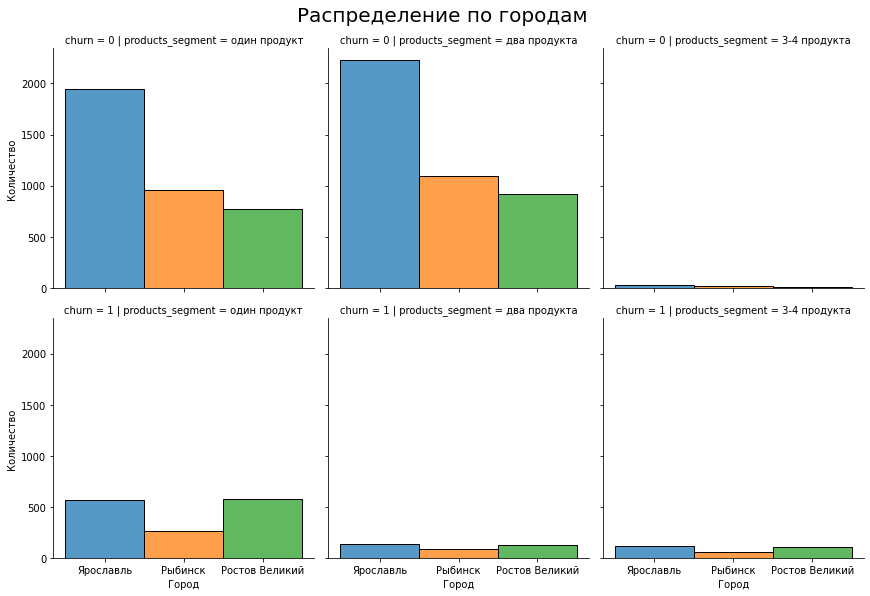

In [28]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='city', row='churn', height=4)
g.map(sns.histplot, 'city')
g.set_axis_labels('Город', 'Количество')
g.fig.suptitle('Распределение по городам', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** по количеству клиентов лидирует г.Ярославль, наибольший процент оттока клиентов приходится на г.Ростов Великий.

#### Распределение по полу

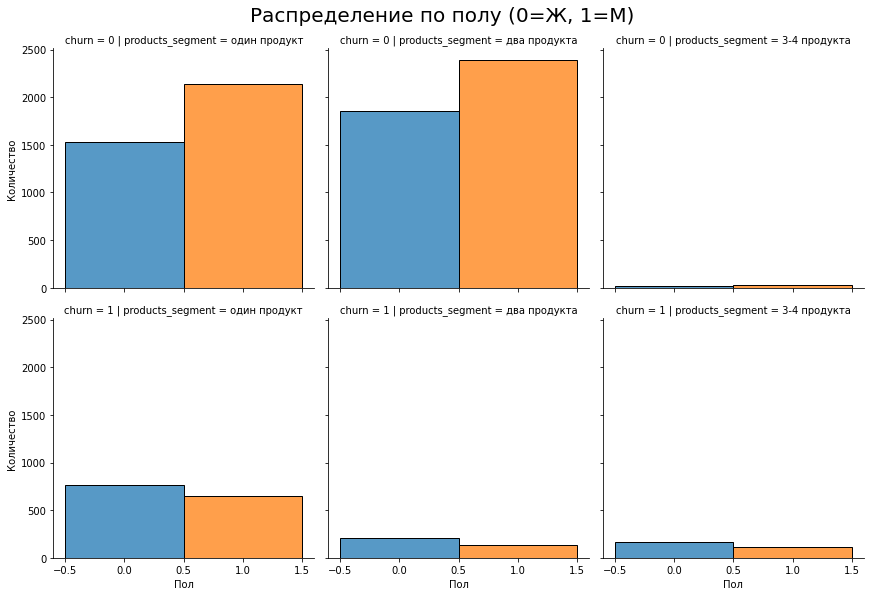

In [29]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='gender', row='churn', height=4)
g.map(sns.histplot, 'gender')
g.set_axis_labels('Пол', 'Количество')
g.fig.suptitle('Распределение по полу (0=Ж, 1=М)', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** клиенты женского пола склонны больше уходить в отток, чем клиенты мужского пола.

#### Распределение по наличию кредитной карты

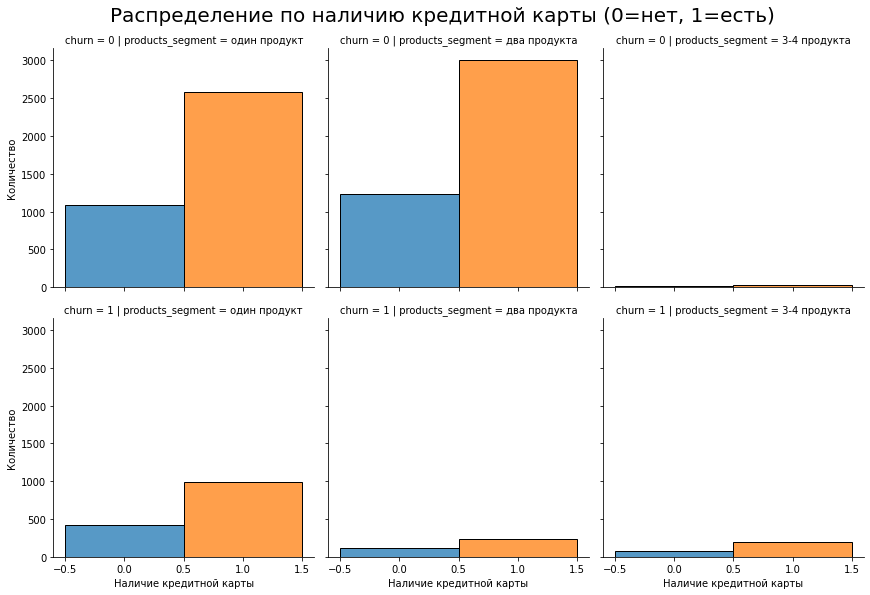

In [30]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='credit_card', row='churn', height=4)
g.map(sns.histplot, 'credit_card')
g.set_axis_labels('Наличие кредитной карты', 'Количество')
g.fig.suptitle('Распределение по наличию кредитной карты (0=нет, 1=есть)', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** примерно 2/3 клиентов обладают кредитной картой вне зависимости, попадают они в отток или нет.

#### Распределение по активности

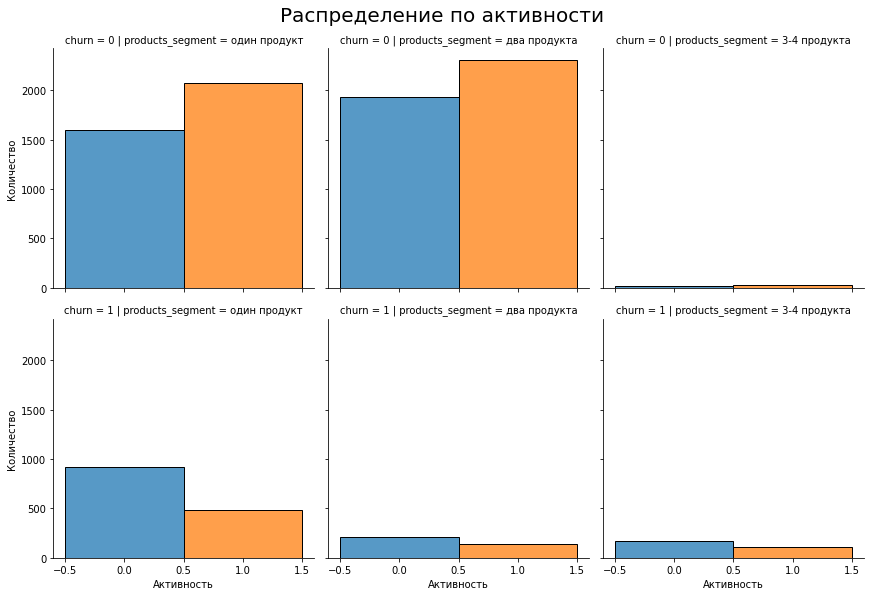

In [31]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='loyalty', row='churn', height=4)
g.map(sns.histplot, 'loyalty')
g.set_axis_labels('Активность', 'Количество')
g.fig.suptitle('Распределение по активности', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** активные клиенты не склонны уходить в отток.

#### Распределение по оттоку клиентов

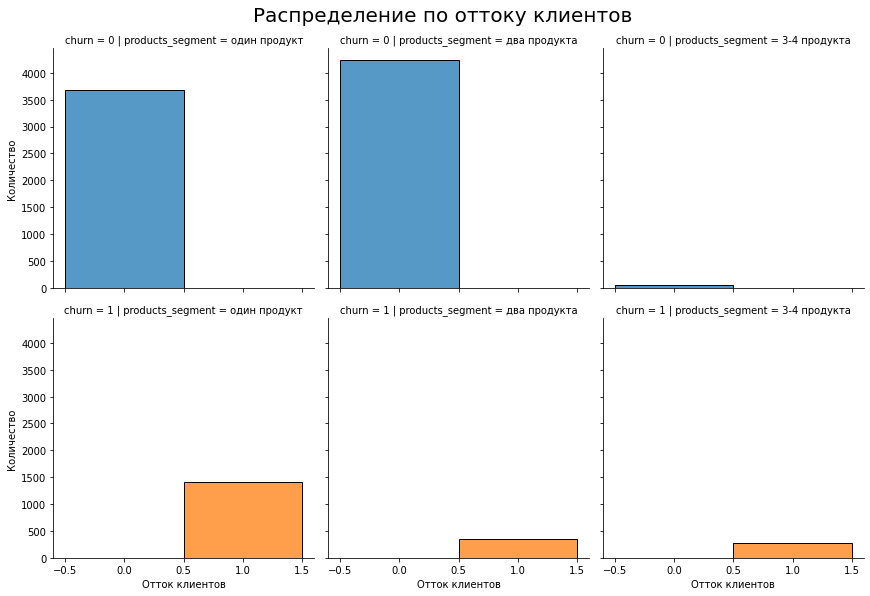

In [32]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', row='churn', height=4)
g.map(sns.histplot, 'churn')
g.set_axis_labels('Отток клиентов', 'Количество')
g.fig.suptitle('Распределение по оттоку клиентов', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** при использовании второго продукта значительно снижается отток клиентов. Использующие 3 продукта автоматически попадают в группу риска, т.к. последний 4-ый продукт - закрытие счета.

#### Распределение по баллам кредитного скоринга

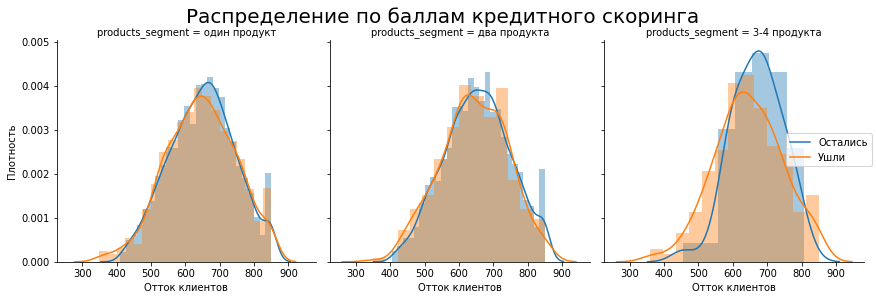

In [33]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', height=4)
g.map(sns.distplot, 'score')
g.set_axis_labels('Отток клиентов', 'Плотность')
g.fig.legend(labels = ('Остались', 'Ушли'), loc = 5)
g.fig.suptitle('Распределение по баллам кредитного скоринга', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** к оттоку склонны клиенты с более низкими баллами предитного скоринга.

#### Распределение по возрасту

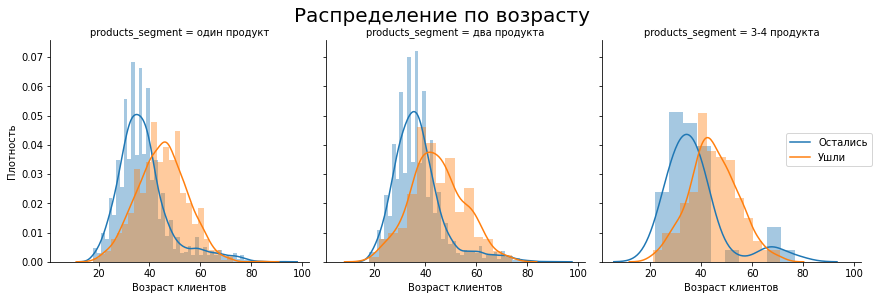

In [34]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', height=4)
g.map(sns.distplot, 'age')
g.set_axis_labels('Возраст клиентов', 'Плотность')
g.fig.legend(labels = ('Остались', 'Ушли'), loc = 5)
g.fig.suptitle('Распределение по возрасту', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** клиенты со средним возрастом 30-40 лет менее склонны к оттоку, чем клиенты с возрастом 40-50 лет.

#### Распределение по количеству объектов в собственности

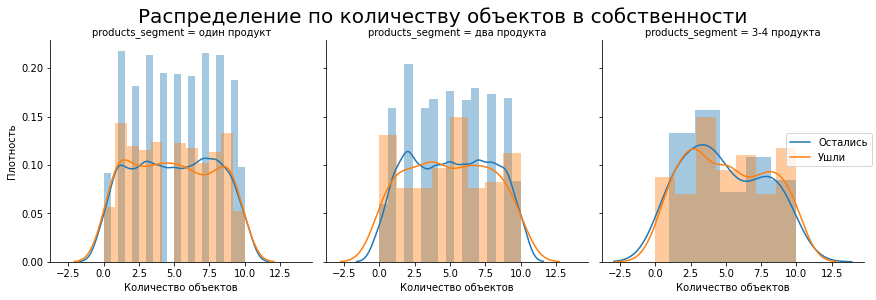

In [35]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', height=4)
g.map(sns.distplot, 'objects')
g.set_axis_labels('Количество объектов', 'Плотность')
g.fig.legend(labels = ('Остались', 'Ушли'), loc = 5)
g.fig.suptitle('Распределение по количеству объектов в собственности', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** для сегментов с двумя и более продуктами стоит обратить внимание на клиентов с минимальным/максимальным количеством объектов, т.к. они более склонны к оттоку.

#### Распределение по балансу на счете

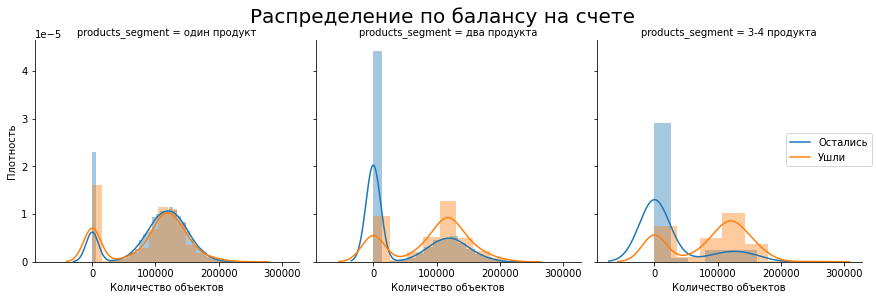

In [36]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', height=4)
g.map(sns.distplot, 'balance')
g.set_axis_labels('Количество объектов', 'Плотность')
g.fig.legend(labels = ('Остались', 'Ушли'), loc = 5)
g.fig.suptitle('Распределение по балансу на счете', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** в среднем у клиентов банка на балансе более 100тыс.руб.

#### Распределение по заработной плате

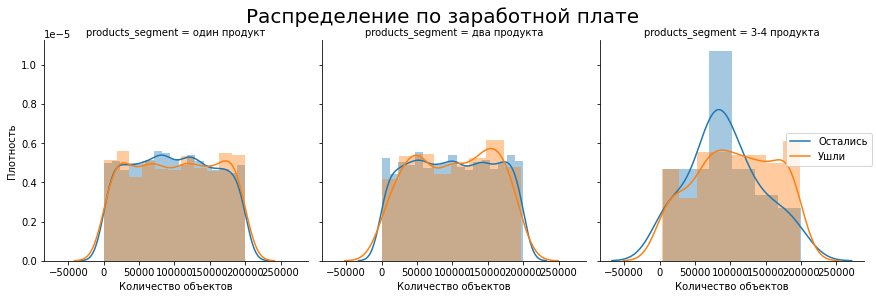

In [37]:
# Создание многосегментного графика
g = sns.FacetGrid(data=df.sort_values(by='products_segment', ascending = False), col='products_segment', hue='churn', height=4)
g.map(sns.distplot, 'estimated_salary')
g.set_axis_labels('Количество объектов', 'Плотность')
g.fig.legend(labels = ('Остались', 'Ушли'), loc = 5)
g.fig.suptitle('Распределение по заработной плате', y = 1.03, fontsize = 20)
plt.show()

**Вывод:** клиенты с высоким уровнем дохода более сконны уходить в отток.

## Проверка гипотез

### Гипотеза различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним.
**Нулевая гипотеза:** доход клиентов, которые используют один продукт не превосходит доход клиентов, которые используют два продукта

**Альтернативная гипотеза:** сдоход клиентов, которые используют один продукт превосходит доход клиентов, которые используют два продукта

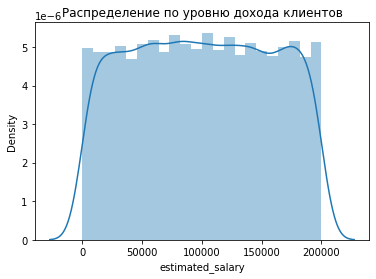

In [38]:
# Построение распределения по уровню дохода клиентов
sns_plot = sns.distplot(df['estimated_salary'])
fig = sns_plot.get_figure()
plt.title('Распределение по уровню дохода клиентов')
plt.show()

График больше похож на равномерное распределение, поэтому при проверке гипотез используется **U-критерий (Манна-Уитни)** - это статистический критерий, используемый для оценки различий между двумя независимыми выборками по уровню какого-либо признака, измеренного количественно. Позволяет выявлять различия в значении параметра между малыми выборками.

In [39]:
results = st.mannwhitneyu(df[df['products']==1]['estimated_salary'], df[df['products']==2]['estimated_salary'])
pvalue = results.pvalue

# Критический уровень статистической значимости 
alpha = 0.05

print('p-значение: ', pvalue)

if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.40796286066317733
Не получилось отвергнуть нулевую гипотезу


**Вывод:** `доход клиентов, которые используют один продукт не превосходит доход клиентов, которые используют два продукта`, т.к. вероятность получить среднее значение дохода клиента, использующего один продукт в выборке доходов клиентов с двумя продуктами равна 41% (нулевая гипотеза не может быть отвергнута).

### Гипотеза различия возраста между теми клиентами, которые ушли и теми, которые остались
**Нулевая гипотеза:** возраст клиентов, которые ушли и возраст клиентов, которые остались не различается

**Альтернативная гипотеза:** возраст клиентов, которые ушли и возраст клиентов, которые остались различается

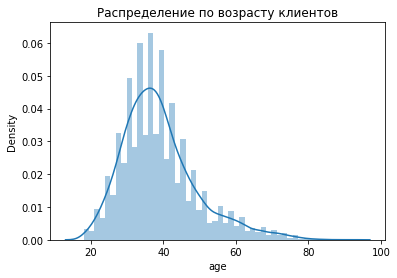

In [40]:
# Построение распределения по возрасту клиентов
sns_plot = sns.distplot(df['age'])
fig = sns_plot.get_figure()
plt.title('Распределение по возрасту клиентов')
plt.show()

График похож на нормальное распределение, поэтому при проверке гипотез используется **t-критерий Стьюдента** - общее название для класса методов статистической проверки гипотез (статистических критериев), основанных на распределении Стьюдента. Наиболее частые случаи применения t-критерия связаны с проверкой равенства средних значений в двух выборках.

In [41]:
# т.к. выборки разного размера используется equal_var = False
results = st.ttest_ind(df[df['churn']==1]['age'], df[df['churn']==0]['age'], equal_var = False)

# критический уровень статистической значимости 
alpha = .05 

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 4.7127272656641046e-179
Отвергаем нулевую гипотезу


In [42]:
# Средний возраст тех, кто попал в отток и тех, кто остался
df.groupby('churn')['age'].mean()

churn
0    37.408389
1    44.837997
Name: age, dtype: float64

In [43]:
# Медианный возраст тех, кто попал в отток и тех, кто остался
df.groupby('churn')['age'].median()

churn
0    36
1    45
Name: age, dtype: int64

**Вывод:** `возраст клиентов, которые ушли и возраст клиентов, которые остались различается`, т.к. вероятность получить среднее значение возраста клиентов, которые ушли в выборке возраста клиентов, которые остались близка к нулю.

## Общий вывод:

В исходных данных **10 000 записей**, в т.ч. представлены следующие критерии:
* баллы кредитного скоринга от 350 до 850;
* возраст клиентов от 18 до 92 лет (средний - 39 лет);
* количество объектов в собственности от 0 до 10 (в среднем 5);
* баланс на счёте от 3 769 до 250 898 (в среднем 119 827) с пропусками значений в доле 1/3;
* количество продуктов, которыми пользуется клиент от 1 до 4 (один из продуктов банка - это закрытие счета);
* заработная плата клиента от 12 до 199 992.
* кредитные карты имеют 2/3 клиентов банка (в т.ч. с нулевым балансом);
* отток клиентов банка составляет 20%.


**Возможные причины пропусков**: технический сбой в Ярославле и Рыбинске (следует сравнить работу системы с Ростовом Великим); отсутствие данных или отсутствие банковского счета (одного из продуктов) при оформлении.

**Равномерное распределение заработной платы** говорит об использовании алгоритма заполнения данных, который стоит проверить/доработать, т.к. клиенты с доходом меньше МРОТ имеют на счету значительные суммы сбережений.


**Сегмент 1 (клиенты, использующие один продукт):** в отток попадают клиенты, средний возраст которых составляет 40-50 лет, в разрезе городов наибольшим % оттока клиентов обладает г.Ростов Великий. Чаще уходят клиенты женского пола, а также клиенты с низкой активностью. Для постоянных клиентов характерно наличие высоких баллов кредитного скоринга, проживание в г.Рыбинске, высокая активность, возраст до 40 лет. Мужчины попадают в отток реже, чем женщины.

`Рекомендации:`
1. Повысить заинтересованность клиентов в использовании второго продукта (провести акции, активизировать колл-центр, поднять охват предложений);
2. Для женского пола возможно следует провести анкетирование при закрытии счета с указанием причины ухода из банка или собрать обратную связь через колл-центр (возможно кто-то из персонала позволяет себе лишнее при выполнении должностных обязанностей, либо недостаточный сервис);
3. Клиенты с возрастом 40+ лет более склонны к оттоку, возможно банк используют передовые технологии, которые трудно даются старшему поколению. Следует адаптирвать продукты под эту возрастную категорию клиентов;
4. Большинство клиентов склонных к оттоку проживает в городе Ростове Великом, возможно ротация кадров позволит сгладить отток между филиалами.


**Сегмент 2 (клиенты, использующие два продукта):** относительно сегмента с использованием одного продукта наблюдается значительное сокращение оттока, следовательно второй продукт повышает удержание клиентов.

`Рекомендации:` аналогичные сегмету 1.


**Сегмент 3 (клиенты, использующие 3-4 продукта):** клиенты, использующие 3 продукта автоматически попадают в группу риска, т.к. последний продукт - закрытие счета. Количество клиентов использующих 3-4 продукта значительно ниже первых двух сегментов и составляет всего 3% от общего количества данных.

`Рекомендации:` к оставшимся клиентам в третьем сегменте, которые используют 3 продукта стоит уделить особое внимание, т.к. имеется высокий риск оттока. 

# Ссылки на презентацию и dashboard:

https://disk.yandex.ru/i/wImLy1cNZ3FW6A

https://public.tableau.com/app/profile/viktor5801/viz/Final_project_16606988168100/Dashboard1